# Lab3

## 環境建置

In [1]:
# TEST necessary for when working with external scripts
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.layers import Input, BatchNormalization, LSTM, GRU, Bidirectional
from tensorflow.keras.layers import TimeDistributed, Reshape, Concatenate
from tensorflow.keras.regularizers import l2

In [3]:
# 定義混合模型 - CNN + LSTM + GRU
def build_hybrid_model(input_shape, num_classes):
    """
    建立一個混合模型，結合CNN、LSTM和GRU
    CNN用於特徵提取，LSTM和GRU用於捕捉時間依賴關係
    
    參數:
    input_shape -- 輸入數據的形狀，例如 (1, n_features, 1)
    num_classes -- 分類類別數量
    """
    # 定義輸入層
    inputs = Input(shape=input_shape)
    
    # CNN部分 - 用於特徵提取
    # 第一組卷積層
    x = Conv2D(32, kernel_size=(1, 3), activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Conv2D(32, kernel_size=(1, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(1, 2))(x)
    x = Dropout(0.25)(x)
    
    # 第二組卷積層
    x = Conv2D(64, kernel_size=(1, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(1, 2))(x)
    
    # 為LSTM準備數據 - 需要重塑為 (batch_size, time_steps, features)
    # 假設經過池化後的數據形狀為 (batch_size, 1, n_features/4, 64)
    # 我們可以將其視為時間序列 (time_steps=n_features/4, features=64)
    cnn_shape = x.shape[1:]
    x_reshaped = Reshape((-1, cnn_shape[-1]))(x)  # 將其轉換為 (batch_size, time_steps, features)
    
    # LSTM部分 - 用於捕捉時間依賴性
    lstm_out = Bidirectional(LSTM(64, return_sequences=True))(x_reshaped)
    lstm_out = Dropout(0.3)(lstm_out)
    
    # GRU部分 - 另一種捕捉時間依賴性的方法
    gru_out = GRU(64, return_sequences=False)(lstm_out)
    gru_out = Dropout(0.3)(gru_out)
    
    # 添加全連接層進行分類
    dense1 = Dense(128, activation='relu')(gru_out)
    dense1 = BatchNormalization()(dense1)
    dense1 = Dropout(0.5)(dense1)
    
    dense2 = Dense(64, activation='relu')(dense1)
    dense2 = Dropout(0.4)(dense2)
    
    # 輸出層
    outputs = Dense(num_classes, activation='softmax')(dense2)
    
    # 構建模型
    model = Model(inputs=inputs, outputs=outputs)
    return model

# 構建另一種混合模型 - CNN + 雙向LSTM
def build_cnn_bilstm_model(input_shape, num_classes):
    """
    建立CNN與雙向LSTM結合的混合模型
    
    參數:
    input_shape -- 輸入數據的形狀，例如 (1, n_features, 1)
    num_classes -- 分類類別數量
    """
    # 定義輸入層
    inputs = Input(shape=input_shape)
    
    # CNN部分 - 特徵提取
    x = Conv2D(32, kernel_size=(1, 3), activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(1, 2))(x)
    
    x = Conv2D(64, kernel_size=(1, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(1, 2))(x)
    
    # 為LSTM準備數據 - 將二維特徵映射重塑為序列
    x_shape = x.shape
    x_reshaped = Reshape((-1, 64))(x)  # 假設最後一個維度是64個過濾器
    
    # 雙向LSTM層
    bilstm = Bidirectional(LSTM(128, return_sequences=True))(x_reshaped)
    bilstm = Dropout(0.3)(bilstm)
    
    # 再添加一層雙向LSTM
    bilstm = Bidirectional(LSTM(64))(bilstm)
    bilstm = Dropout(0.3)(bilstm)
    
    # 全連接層
    x = Dense(128, activation='relu')(bilstm)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    
    # 輸出層
    outputs = Dense(num_classes, activation='softmax')(x)
    
    # 構建模型
    model = Model(inputs=inputs, outputs=outputs)
    return model

# 構建CNN + 1D CNN混合模型
def build_cnn_1dcnn_model(input_shape, num_classes):
    """
    建立CNN與1D CNN結合的混合模型
    使用2D CNN進行初步特徵提取，然後使用1D CNN處理序列數據
    
    參數:
    input_shape -- 輸入數據的形狀，例如 (1, n_features, 1)
    num_classes -- 分類類別數量
    """
    from tensorflow.keras.layers import Conv1D, MaxPooling1D
    
    # 定義輸入層
    inputs = Input(shape=input_shape)
    
    # 2D CNN部分
    x = Conv2D(32, kernel_size=(1, 3), activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(1, 2))(x)
    
    x = Conv2D(64, kernel_size=(1, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(1, 2))(x)
    
    # 重塑為1D CNN的輸入格式
    # 假設經過池化後的數據形狀為 (batch_size, 1, n_features/4, 64)
    x_shape = x.shape
    x_reshaped = Reshape((-1, 64))(x)  # 轉換為 (batch_size, time_steps, features)
    
    # 1D CNN部分
    x = Conv1D(128, kernel_size=3, activation='relu', padding='same')(x_reshaped)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2)(x)
    
    x = Conv1D(256, kernel_size=3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2)(x)
    
    # 展平層
    x = Flatten()(x)
    
    # 全連接層
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.4)(x)
    
    # 輸出層
    outputs = Dense(num_classes, activation='softmax')(x)
    
    # 構建模型
    model = Model(inputs=inputs, outputs=outputs)
    return model

# 構建CNN + Transformer混合模型
def build_cnn_transformer_model(input_shape, num_classes):
    """
    建立CNN與Transformer結合的混合模型
    CNN用於特徵提取，Transformer用於捕捉長距離依賴關係
    
    參數:
    input_shape -- 輸入數據的形狀，例如 (1, n_features, 1)
    num_classes -- 分類類別數量
    """
    from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, Add
    
    # 定義輸入層
    inputs = Input(shape=input_shape)
    
    # CNN部分 - 特徵提取
    x = Conv2D(32, kernel_size=(1, 3), activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(1, 2))(x)
    
    x = Conv2D(64, kernel_size=(1, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(1, 2))(x)
    
    # 為Transformer準備數據
    x_shape = x.shape
    x_reshaped = Reshape((-1, 64))(x)  # 將其轉換為 (batch_size, seq_len, features)
    
    # Transformer編碼器部分
    # 自注意力機制
    attn_output = MultiHeadAttention(num_heads=4, key_dim=16)(x_reshaped, x_reshaped)
    x_norm = LayerNormalization(epsilon=1e-6)(Add()([x_reshaped, attn_output]))
    
    # 前饋神經網絡
    ffn_output = Dense(128, activation='relu')(x_norm)
    ffn_output = Dense(64)(ffn_output)
    x_norm2 = LayerNormalization(epsilon=1e-6)(Add()([x_norm, ffn_output]))
    
    # 全局池化
    x = Flatten()(x_norm2)
    
    # 全連接層
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    
    # 輸出層
    outputs = Dense(num_classes, activation='softmax')(x)
    
    # 構建模型
    model = Model(inputs=inputs, outputs=outputs)
    return model

# 構建平行結構混合模型 (CNN + LSTM 雙路徑)
def build_parallel_cnn_lstm_model(input_shape, num_classes):
    """
    建立具有平行結構的混合模型，同時使用CNN和LSTM進行特徵提取
    然後合併兩個路徑的特徵
    
    參數:
    input_shape -- 輸入數據的形狀，例如 (1, n_features, 1)
    num_classes -- 分類類別數量
    """
    # 定義輸入層
    inputs = Input(shape=input_shape)
    
    # CNN路徑
    cnn = Conv2D(32, kernel_size=(1, 3), activation='relu', padding='same')(inputs)
    cnn = BatchNormalization()(cnn)
    cnn = MaxPooling2D(pool_size=(1, 2))(cnn)
    
    cnn = Conv2D(64, kernel_size=(1, 3), activation='relu', padding='same')(cnn)
    cnn = BatchNormalization()(cnn)
    cnn = MaxPooling2D(pool_size=(1, 2))(cnn)
    
    cnn = Flatten()(cnn)
    cnn = Dense(128, activation='relu')(cnn)
    cnn = Dropout(0.3)(cnn)
    
    # LSTM路徑 - 首先需要重塑輸入
    # 假設輸入形狀為 (batch_size, 1, n_features, 1)
    lstm_input = Reshape((-1, 1))(inputs)  # 轉換為 (batch_size, time_steps, features)
    
    lstm = Bidirectional(LSTM(64, return_sequences=True))(lstm_input)
    lstm = Dropout(0.3)(lstm)
    lstm = Bidirectional(LSTM(32))(lstm)
    lstm = Dense(128, activation='relu')(lstm)
    lstm = Dropout(0.3)(lstm)
    
    # 合併兩條路徑
    merged = Concatenate()([cnn, lstm])
    
    # 全連接層
    x = Dense(128, activation='relu')(merged)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    
    # 輸出層
    outputs = Dense(num_classes, activation='softmax')(x)
    
    # 構建模型
    model = Model(inputs=inputs, outputs=outputs)
    return model


In [4]:


# 讀取數據
#df = pd.read_csv("../WESAD/s2_data.csv")
df = pd.read_csv("../Output/lab3_data.csv")
df = df.sample(frac=0.01)
print(f"數據集大小: {len(df)}")

# 分開特徵和標籤
X = df.drop(columns=['Label','Subject'])  # 移除標籤 (y)  
y = df['Label'] 
print(f"特徵矩陣形狀: {X.shape}")
print("特徵數據前5行:")
print(X.head())

# 確定實際特徵數量
n_features = X.shape[1]
print(f"特徵數量: {n_features}")

num_classes = 2
print(f"類別數量: {num_classes}")

# 正確的數據重塑方式 - 根據特徵結構調整
X_reshaped = X.values.reshape(X.shape[0], 1, n_features, 1)
input_shape = (1, n_features, 1)
print(f"重塑後的數據形狀: {X_reshaped.shape}")

# 標籤處理 - 將標籤調整為從0開始
y_adjusted = y - 1  # 如果標籤是1和2，調整為0和1

# 切分訓練集和測試集
X_train, X_test, y_train, y_test = train_test_split(
    X_reshaped, y_adjusted, test_size=0.2, random_state=42  
)



# 選擇使用哪個模型 (可以根據需要更改)
# 1. CNN + LSTM + GRU混合模型
#model = build_hybrid_model(input_shape, num_classes)

# 2. CNN + 雙向LSTM混合模型
model = build_cnn_bilstm_model(input_shape, num_classes)

# 3. CNN + 1D CNN混合模型 xx
#model = build_cnn_1dcnn_model(input_shape, num_classes)

# 4. CNN + Transformer混合模型
# model = build_cnn_transformer_model(input_shape, num_classes)

# 5. 平行結構 CNN + LSTM模型
# model = build_parallel_cnn_lstm_model(input_shape, num_classes)

# 輸出模型摘要以檢查結構
model.summary()

# 編譯模型
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# 訓練模型 - 添加批次大小參數以避免可能的內存問題
batch_size = 32
epochs = 250

# 訓練模型
history = model.fit(
    X_train, y_train, 
    batch_size=batch_size,
    epochs=epochs, 
    validation_data=(X_test, y_test),
    verbose=1
)

# 評估模型
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)
print(f'測試準確率: {test_acc:.4f}')


數據集大小: 193039
特徵矩陣形狀: (193039, 5)
特徵數據前5行:
          ecg_singal  EMG_signal  EDA_signal  Resp_signal  Temp_signal
14739024    0.477317    0.592103    0.182918     0.568380     0.996809
15154809    0.522850    0.587916    0.473910     0.610049     0.996322
11948896    0.504967    0.582650    0.568114     0.597757     0.995676
19137727    0.460075    0.589551    0.092766     0.563241     0.984787
1348970     0.538109    0.586676    0.050443     0.657430     0.992378
特徵數量: 5
類別數量: 2
重塑後的數據形狀: (193039, 1, 5, 1)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1, 5, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 1, 5, 32)       │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1, 5, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 1, 2, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 1, 2, 64)       │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1, 2, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 1, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 1, 256)         │       197,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 385,986 (1.47 MB)

 Trainable params: 385,538 (1.47 MB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/250
1967/4826 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.7140 - loss: 0.5566

KeyboardInterrupt: 

In [7]:
# 讀取數據
#df = pd.read_csv("../WESAD/s2_data.csv")
df = pd.read_csv("../Output/lab3_data.csv")
df = df.sample(frac=0.01)
print(f"數據集大小: {len(df)}")

# 分開特徵和標籤
X = df.drop(columns=['Label','Subject'])  # 移除標籤 (y)  
y = df['Label'] 
print(f"特徵矩陣形狀: {X.shape}")
print("特徵數據前5行:")
print(X.head())

# 確定實際特徵數量
n_features = X.shape[1]
print(f"特徵數量: {n_features}")

num_classes = 2
print(f"類別數量: {num_classes}")

# 正確的數據重塑方式 - 根據特徵結構調整
X_reshaped = X.values.reshape(X.shape[0], 1, n_features, 1)
input_shape = (1, n_features, 1)
print(f"重塾後的數據形狀: {X_reshaped.shape}")

# 標籤處理 - 將標籤調整為從0開始
y_adjusted = y - 1  # 如果標籤是1和2，調整為0和1

# 切分訓練集和測試集
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_reshaped, y_adjusted, test_size=0.2, random_state=42  
)

# 安裝 keras-tuner (如果尚未安裝)
# 在命令列執行: pip install keras-tuner

# 導入必要的模組
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt
import numpy as np
import matplotlib.pyplot as plt

# 定義模型構建函數，用於keras-tuner
def build_model(hp):
    # 超參數範圍定義
    conv_filters = hp.Int('conv_filters', min_value=16, max_value=64, step=16)
    dropout_rate = hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)
    lstm_units = hp.Int('lstm_units', min_value=32, max_value=128, step=32)
    learning_rate = hp.Choice('learning_rate', values=[0.001, 0.0005, 0.0001])
    
    # 建立模型
    inputs = keras.Input(shape=input_shape)
    
    # CNN部分
    x = layers.Conv2D(filters=conv_filters, kernel_size=(1, 3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D(pool_size=(1, 2))(x)
    x = layers.Conv2D(filters=conv_filters*2, kernel_size=(1, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D(pool_size=(1, 2))(x)
    
    # 重塑以便LSTM處理
    x = layers.TimeDistributed(layers.Flatten())(x)
    
    # 雙向LSTM部分
    x = layers.Bidirectional(layers.LSTM(units=lstm_units, return_sequences=True))(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Bidirectional(layers.LSTM(units=lstm_units//2))(x)
    x = layers.Dropout(dropout_rate)(x)
    
    # 全連接層
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(dropout_rate)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    model = keras.Model(inputs=inputs, outputs=outputs)
    
    # 編譯模型
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

# 定義早停策略
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 創建 Keras Tuner 的 Hyperband 搜索器
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=100,
    factor=3,
    directory='keras_tuner_dir',
    project_name='cnn_bilstm'
)

# 可選：打印搜索空間摘要
tuner.search_space_summary()

# 執行超參數搜索
print("開始超參數搜索...")
tuner.search(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping],
    verbose=1
)

# 打印搜索結果
tuner.results_summary()

# 獲取最佳超參數
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("最佳超參數組合:")
print(f"- Conv Filters: {best_hps.get('conv_filters')}")
print(f"- Dropout Rate: {best_hps.get('dropout_rate')}")
print(f"- LSTM Units: {best_hps.get('lstm_units')}")
print(f"- Learning Rate: {best_hps.get('learning_rate')}")

# 使用最佳超參數構建和訓練最終模型
best_model = tuner.hypermodel.build(best_hps)
batch_size = 32  # 您也可以調整批次大小

# 訓練最終模型
final_history = best_model.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=100,  # 可以設置較長的訓練時間，因為有早停機制
    validation_data=(X_test, y_test),
    callbacks=[early_stopping],
    verbose=1
)

# 評估最終模型
test_loss, test_acc = best_model.evaluate(X_test, y_test, verbose=1)
print(f'測試準確率: {test_acc:.4f}')

# 保存最終模型
best_model.save("../Output/best_model.h5")
print("最佳模型已保存")

# 繪製訓練過程
plt.figure(figsize=(12, 4))

# 準確率曲線
plt.subplot(1, 2, 1)
plt.plot(final_history.history['accuracy'])
plt.plot(final_history.history['val_accuracy'])
plt.title('模型準確率')
plt.ylabel('準確率')
plt.xlabel('Epoch')
plt.legend(['訓練集', '驗證集'], loc='lower right')

# 損失曲線
plt.subplot(1, 2, 2)
plt.plot(final_history.history['loss'])
plt.plot(final_history.history['val_loss'])
plt.title('模型損失')
plt.ylabel('損失')
plt.xlabel('Epoch')
plt.legend(['訓練集', '驗證集'], loc='upper right')

plt.tight_layout()
plt.savefig("../Output/training_history.png")
plt.show()

Trial 180 Complete [00h 01m 13s]
val_accuracy: 0.8255283832550049

Best val_accuracy So Far: 0.9424989819526672
Total elapsed time: 02h 25m 11s

Search: Running Trial #181

Value             |Best Value So Far |Hyperparameter
48                |64                |conv_filters
0.5               |0.2               |dropout_rate
128               |96                |lstm_units
0.0005            |0.0005            |learning_rate
4                 |100               |tuner/epochs
0                 |34                |tuner/initial_epoch
3                 |4                 |tuner/bracket
0                 |4                 |tuner/round

Epoch 1/4
2842/4826 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6605 - loss: 0.6195

KeyboardInterrupt: 

數據集大小: 193039
特徵矩陣形狀: (193039, 5)
特徵數據前5行:
          ecg_singal  EMG_signal  EDA_signal  Resp_signal  Temp_signal
7045496     0.507195    0.585526    0.294035     0.541921     0.996033
4916132     0.455634    0.588329    0.144143     0.608382     0.994529
17369485    0.500603    0.588815    0.319668     0.591125     0.985596
17761772    0.500633    0.591546    0.377056     0.558467     0.993564
13806446    0.390188    0.581321    0.304397     0.538275     0.993879
特徵數量: 5
類別數量: 2
重塾後的數據形狀: (193039, 1, 5, 1)
Epoch 1/100
4826/4826 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.7008 - loss: 0.5673 - val_accuracy: 0.7575 - val_loss: 0.4799
Epoch 2/100
4826/4826 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.7782 - loss: 0.4608 - val_accuracy: 0.8013 - val_loss: 0.4210
Epoch 3/100
4826/4826 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.7977 - loss: 0.4298 - val_accuracy: 0.8460 - val_loss: 0.3764
Epoch 4/100
4826/4826 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.8232 - loss: 0.4033 - va

測試準確率: 0.9298
最佳模型已保存


/var/folders/q5/67lzv4sn4f3gymk3dxsv105r0000gn/T/ipykernel_66163/2749503208.py:130: UserWarning: Glyph 28310 (\N{CJK UNIFIED IDEOGRAPH-6E96}) missing from current font.
  plt.tight_layout()
/var/folders/q5/67lzv4sn4f3gymk3dxsv105r0000gn/T/ipykernel_66163/2749503208.py:130: UserWarning: Glyph 30906 (\N{CJK UNIFIED IDEOGRAPH-78BA}) missing from current font.
  plt.tight_layout()
/var/folders/q5/67lzv4sn4f3gymk3dxsv105r0000gn/T/ipykernel_66163/2749503208.py:130: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from current font.
  plt.tight_layout()
/var/folders/q5/67lzv4sn4f3gymk3dxsv105r0000gn/T/ipykernel_66163/2749503208.py:130: UserWarning: Glyph 27169 (\N{CJK UNIFIED IDEOGRAPH-6A21}) missing from current font.
  plt.tight_layout()
/var/folders/q5/67lzv4sn4f3gymk3dxsv105r0000gn/T/ipykernel_66163/2749503208.py:130: UserWarning: Glyph 22411 (\N{CJK UNIFIED IDEOGRAPH-578B}) missing from current font.
  plt.tight_layout()
/var/folders/q5/67lzv4sn4f3gymk3dxsv105r0000gn/T/i

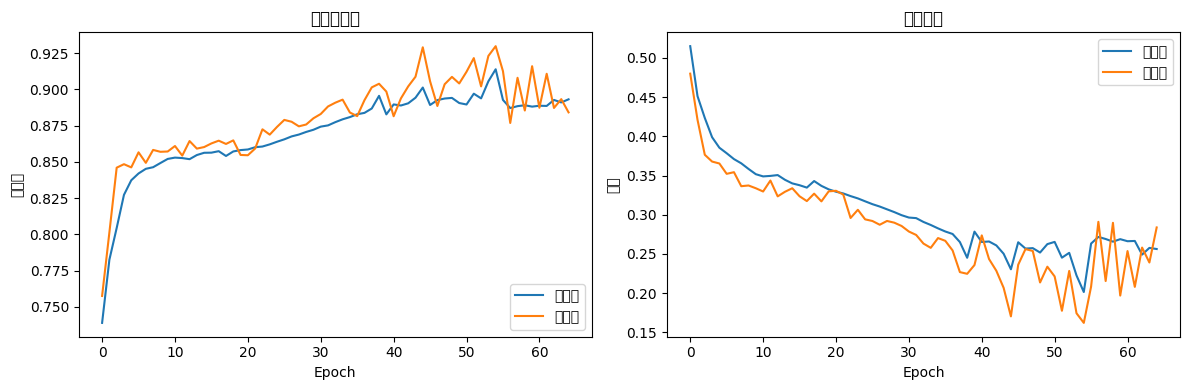

In [9]:
#調好參數
# 讀取數據
df = pd.read_csv("../Output/lab3_data.csv")
df = df.sample(frac=0.01)
print(f"數據集大小: {len(df)}")

# 分開特徵和標籤
X = df.drop(columns=['Label','Subject'])  # 移除標籤 (y)  
y = df['Label'] 
print(f"特徵矩陣形狀: {X.shape}")
print("特徵數據前5行:")
print(X.head())

# 確定實際特徵數量
n_features = X.shape[1]
print(f"特徵數量: {n_features}")

num_classes = 2
print(f"類別數量: {num_classes}")

# 正確的數據重塑方式 - 根據特徵結構調整
X_reshaped = X.values.reshape(X.shape[0], 1, n_features, 1)
input_shape = (1, n_features, 1)
print(f"重塾後的數據形狀: {X_reshaped.shape}")

# 標籤處理 - 將標籤調整為從0開始
y_adjusted = y - 1  # 如果標籤是1和2，調整為0和1

# 切分訓練集和測試集
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_reshaped, y_adjusted, test_size=0.2, random_state=42  
)

# 導入必要的模組
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import matplotlib.pyplot as plt

# 定義模型構建函數
def build_model():
    # 使用固定的參數
    conv_filters = 64
    dropout_rate = 0.2
    lstm_units = 96
    learning_rate = 0.0005
    
    # 建立模型
    inputs = keras.Input(shape=input_shape)
    
    # CNN部分
    x = layers.Conv2D(filters=conv_filters, kernel_size=(1, 3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D(pool_size=(1, 2))(x)
    x = layers.Conv2D(filters=conv_filters*2, kernel_size=(1, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D(pool_size=(1, 2))(x)
    
    # 重塑以便LSTM處理
    x = layers.TimeDistributed(layers.Flatten())(x)
    
    # 雙向LSTM部分
    x = layers.Bidirectional(layers.LSTM(units=lstm_units, return_sequences=True))(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Bidirectional(layers.LSTM(units=lstm_units//2))(x)
    x = layers.Dropout(dropout_rate)(x)
    
    # 全連接層
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(dropout_rate)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    model = keras.Model(inputs=inputs, outputs=outputs)
    
    # 編譯模型
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

# 定義早停策略
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 使用固定的參數建立模型
model = build_model()

# 訓練模型
batch_size = 32  # 您也可以調整批次大小
final_history = model.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=100,  # 可以設置較長的訓練時間，因為有早停機制
    validation_data=(X_test, y_test),
    callbacks=[early_stopping],
    verbose=1
)

# 評估最終模型
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)
print(f'測試準確率: {test_acc:.4f}')

# 保存最終模型
model.save("../Output/best_model.h5")
print("最佳模型已保存")

# 繪製訓練過程
plt.figure(figsize=(12, 4))

# 準確率曲線
plt.subplot(1, 2, 1)
plt.plot(final_history.history['accuracy'])
plt.plot(final_history.history['val_accuracy'])
plt.title('模型準確率')
plt.ylabel('準確率')
plt.xlabel('Epoch')
plt.legend(['訓練集', '驗證集'], loc='lower right')

# 損失曲線
plt.subplot(1, 2, 2)
plt.plot(final_history.history['loss'])
plt.plot(final_history.history['val_loss'])
plt.title('模型損失')
plt.ylabel('損失')
plt.xlabel('Epoch')
plt.legend(['訓練集', '驗證集'], loc='upper right')

plt.tight_layout()
plt.savefig("../Output/training_history.png")
plt.show()


In [10]:
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

# 預測測試集
y_pred = model.predict(X_test)

# 將預測的機率轉換為類別標籤
y_pred_labels = np.argmax(y_pred, axis=1)

# 計算準確率
accuracy = accuracy_score(y_test, y_pred_labels)
print(f"模型準確率: {accuracy:.4f}")

# 輸出分類報告
print("分類報告：")
print(classification_report(y_test, y_pred_labels, digits=4))


1207/1207 ━━━━━━━━━━━━━━━━━━━━ 2s 850us/step
模型準確率: 0.9298
分類報告：
              precision    recall  f1-score   support

         0.0     0.9377    0.9541    0.9458     24803
         1.0     0.9149    0.8861    0.9002     13805

    accuracy                         0.9298     38608
   macro avg     0.9263    0.9201    0.9230     38608
weighted avg     0.9295    0.9298    0.9295     38608

